<a href="https://colab.research.google.com/github/JennyPre/ReinforcementSimple/blob/main/AutonomousCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install gymnasium
! pip install gymnasium stable-baselines3
! pip install mediapy

In [2]:
import gymnasium as gym
import torch.nn as nn
import torch
import mediapy as media
import numpy as np
import torch.optim as optim

In [3]:
env = gym.make('MountainCarContinuous-v0', render_mode='rgb_array')

# run a few episodes with random actions
frames = []
observation, info = env.reset()
rewards = []


for t in range(10000):
  action = env.action_space.sample()
  frames.append(env.render())
  observation, reward, terminated, truncated, info = env.step(action)
  done = terminated or truncated # is termianted, when the car has position 0.45
  rewards.append(reward)

  if done:
    print(f"Episode finished after {t+1} timesteps. Cummulative return: {sum(rewards)}")
    break

media.show_video(frames, fps=50, loop=True)

Episode finished after 999 timesteps. Cummulative return: -33.41969991735135


In [4]:
print(np.mean(rewards)) # the problem is hard, random actions wont solve it
# quick math: 0.5 * 0.5 = 0.25 --> align with mean reward

-0.03345315307042177


## Policy Gradient

- learn a probablity distribution --> sample action
- Whats the probability for each action?


### **Reward Formula (Mountain Car)**

**Larger magnitude = bigger penalty**

$$r_t = -0.1 \times a_t^2$$

Where $a_t$ is the action (force between -1 and 1)

**Special case:** When position ≥ 0.45, add bonus:
$$r_{terminal} = -0.1 \times a_t^2 + 100$$

### **Return Formula (Discounted Cumulative Reward)**

$$G_t = \sum_{k=0}^{\infty} \gamma^k r_{t+k} = r_t + \gamma r_{t+1} + \gamma^2 r_{t+2} + ...$$

**Recursive form:**
$$G_t = r_t + \gamma \cdot G_{t+1}$$

### **Loss Formula**

$$L(\theta) = -\sum_{t=1}^{T} \log \pi_\theta(a_t | s_t) \cdot G_t$$

Where:
- $\pi_\theta(a_t | s_t)$ = probability of action $a_t$ given state $s_t$
- $G_t$ = return from timestep $t$
- Negative sign because we do **gradient descent** (minimize loss)

### **Policy Gradient Theorem (the foundation)**

$$\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \sum_{t=0}^{T} \nabla_\theta \log \pi_\theta(a_t|s_t) \cdot G_t \right]$$

This says: "The gradient of expected return equals the expected gradient of log-probabilities weighted by returns"



---


### Policy Gradient algorithm


#### 1. Collect data from episode

store states, actions, rewards, and how likely each action was (log probability)


#### 2. Compute returns

Discounted sum of future rewards: **How much total reward did I get from this point forward?**


#### 3. Update policy

$$Loss = -log\_prob(action) * return$$





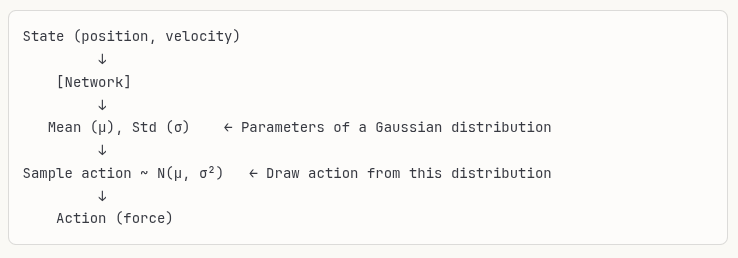


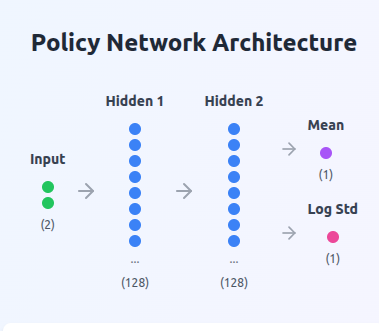

In [11]:
class PolicyNetwork(nn.Module):

    def __init__(self, state_size):
      super(PolicyNetwork, self).__init__()

      # state_size=2 (position, velocity)
      # action_size=1 (acceleration) sampled from resulting distribution

      self.fc1 = nn.Linear(state_size, 128)  # First layer: 2 -> 128  AKA position and velocity
      self.fc2 = nn.Linear(128, 128)         # Hidden layer: 128 -> 128

      self.mean_layer = nn.Linear(128, 1)
      self.log_std_layer = nn.Linear(128, 1)

    def forward(self, x):
        """Pass the state through the network to get the parameters for the distribution"""

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        mean = torch.tanh(self.mean_layer(x)) # tanh to bound between -1 and 1
        log_std = torch.clamp(self.log_std_layer(x), -20, 2) #  prevent extreme values

        return mean, log_std

    def sample_action(self, state):
        """Sample an action from the output distribution"""
        mean, log_std = self.forward(state)
        std = log_std.exp() # Transform from log-space to actual std: e^(log_std) is always > 0
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        # TODO: is this right, shoudl i not use the std from earlier?
        # TODO: why sum, what does the log_prob do?
        log_prob = dist.log_prob(action).sum()
        return action, log_prob # Return log_prob as a tensor

# policyNet = PolicyNetwork(2)
# action, log_prob = policyNet.sample_action(torch.tensor([0.0, 0.0]))
# print(f"Got action {action} and log prob {log_prob}")

In [6]:
class PolicyAgent:
  """The RL Agent that learns to get the car up the hill"""
  def __init__(self, state_size, action_size):
    self.gamma = 0.99  # Discount factor
    self.num_episodes = 1000
    self.lr = 0.001

    self.policy_net = PolicyNetwork(state_size)
    self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.lr)

  def run_episode(self, env):
    """Collect the data from one episode.
    The returnes values will later be used to train the policy network"""

    observation, info = env.reset()
    rewards = []
    log_probs = []
    done = False
    observation = observation

    while not done:
      state = torch.tensor(observation, dtype=torch.float32)
      action, log_prob = self.policy_net.sample_action(state) # observation == state?
      log_probs.append(log_prob)
      observation, reward, terminated, truncated, _ = env.step(action) # if steps > 999 --> truncate
      rewards.append(reward)
      done = terminated or truncated # is termianted, when the car has position 0.45

      # if terminated:
      #   print(f"Reward gotten for success {reward}, is this 100?")

      rewards.append(reward) # rewards are +100 on termination, +1, -1 ...

    return rewards, log_probs

  def compute_returns(self, rewards):
    """Computes the returns (G) for each time step of an episode
    is done in an iterative Backward manner """
    G = 0
    returns = [(G := r + self.gamma * G) for r in reversed(rewards)]
    return torch.tensor(list(reversed(returns)), dtype=torch.float32)

  def calculate_loss(self, log_probs, returns):
    """Calculates the loss with some normalization"""
    returns = (returns - returns.mean()) / (returns.std() + 1e-9) # Return normalization
    # advantages = returns - value_function(states) # Subtract learned baseline (VPG/A2C style)
    return -sum(log_p * G for log_p, G in zip(log_probs, returns))

  def train(self, num_episodes, env):
    episode_rewards = []

    for episode in range(num_episodes):
      rewards, log_probs = self.run_episode(env)
      returns = self.compute_returns(rewards)

      # TODO: where to do loss aggregation?
      # TODO: use the mean() for loss agregation of the policy losses
      loss = self.calculate_loss(log_probs, returns)

      # backprop - update policy each episode
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()


      # Track and log progress
      total_reward = sum(rewards)
      episode_rewards.append(total_reward)

      if episode % 50 == 0:
          avg_reward = np.mean(episode_rewards[-50:])
          print(f"Episode {episode:4d} | Avg Reward: {avg_reward:7.2f} | "
                f"Latest: {total_reward:7.2f}")
    return episode_rewards

# agent = PolicyAgent(env.observation_space.shape[0], env.action_space.shape[0])
agent = PolicyAgent(2,1)
episode_rewards = agent.train(150, env)

Episode    0 | Avg Reward: -292.41 | Latest: -292.41
Episode   50 | Avg Reward:  -72.62 | Latest:  -26.03
Episode  100 | Avg Reward:   -9.73 | Latest:   -8.47


# ✅ ALTERNATIVE: Batch multiple episodes
batch_size = 5
for batch in range(num_batches):
    all_rewards, all_log_probs = [], []
    for _ in range(batch_size):
        rewards, log_probs = run_episode()
        all_rewards.extend(rewards)
        all_log_probs.extend(log_probs)
    # Compute loss over entire batch
    loss = calculate_loss(all_log_probs, all_returns)
    optimizer.step()

In [7]:
episode_rewards

[-292.41409131953,
 -249.2388404320768,
 -165.97350666032213,
 -175.70885643235758,
 -147.56501729994383,
 75.81334619101965,
 -128.90942415886235,
 -117.89212740536604,
 -110.22002210441305,
 -101.07996417806456,
 -99.45110194101996,
 -102.53861603390794,
 -94.46531764204299,
 -98.3538555661717,
 -99.45050728932998,
 -89.31934164385649,
 -98.33195324161166,
 -95.55585142675787,
 -95.52845224378851,
 -87.31114007885401,
 -80.89781232936876,
 -79.48664204555014,
 -71.90492665404692,
 -64.91541368409425,
 -69.28943806877751,
 -62.30215964453911,
 -58.17533316412272,
 -59.19196108664859,
 -57.812420122743376,
 -50.19929495163768,
 -56.39513537736394,
 -56.27835344803911,
 -51.311314312418006,
 -52.29569262282679,
 -50.370343397403644,
 -50.85968274167952,
 -50.26928205041307,
 -45.220627147063965,
 -40.29069959772493,
 -43.2005854197056,
 -42.448818908183306,
 -42.481183865347816,
 -40.473145369685575,
 -41.541066525941226,
 -38.37597173267193,
 -41.23464293851985,
 -34.90393153233796,
 -

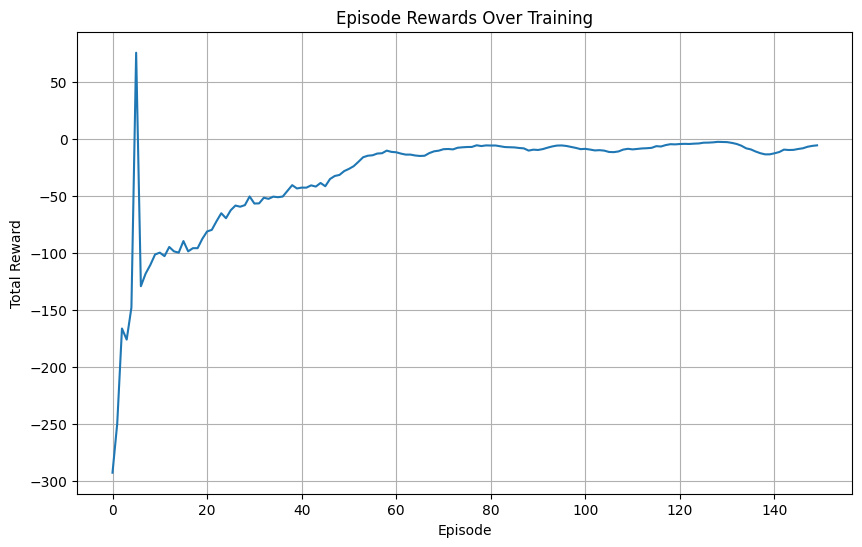

In [8]:
import matplotlib.pyplot as plt

def plot_episode_rewards(episode_rewards):
    """
    Plots the total reward obtained in each episode during training.

    Args:
        episode_rewards: A list of total rewards for each episode.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Episode Rewards Over Training")
    plt.grid(True)
    plt.show()

# Example usage (after training your agent and getting episode_rewards):
# episode_rewards = agent.train(num_episodes, env) # Assuming train returns the list
plot_episode_rewards(episode_rewards)




- import sac for stable-baselines3
- create a simple traing loop
- save the model
- test it ...


### SAC - Soft Actor-Critic

- continuous action and state space
- Actor Critic
- for precise continuous control
- more advanced

